# Assignment 5

In this assignment, you'll scrape text from [The California Aggie](https://theaggie.org/) and then analyze the text.

The Aggie is organized by category into article lists. For example, there's a [Campus News](https://theaggie.org/campus/) list, [Arts & Culture](https://theaggie.org/arts/) list, and [Sports](https://theaggie.org/sports/) list. Notice that each list has multiple pages, with a maximum of 15 articles per page.

The goal of exercises 1.1 - 1.3 is to scrape articles from the Aggie for analysis in exercise 1.4.

__Exercise 1.1.__ Write a function that extracts all of the links to articles in an Aggie article list. The function should:

* Have a parameter `url` for the URL of the article list.

* Have a parameter `page` for the number of pages to fetch links from. The default should be `1`.

* Return a list of aricle URLs (each URL should be a string).

Test your function on 2-3 different categories to make sure it works.

Hints:

* Be polite to The Aggie and save time by setting up [requests_cache](https://pypi.python.org/pypi/requests-cache) before you write your function.

* Start by getting your function to work for just 1 page. Once that works, have your function call itself to get additional pages.

* You can use [lxml.html](http://lxml.de/lxmlhtml.html) or [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to scrape HTML. Choose one and use it throughout the entire assignment.

In [753]:
import requests
from lxml import html
import requests_cache
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt
#requests_cache.install_cache('db_cache')

In [61]:
def link_extract(url, page=1):
    ''' Scrape article linkes of a given article list
    Args:
        url: the URL of the article list
        page: the number of pages to fetch links from. The default should be 1
    Returns:
        a list of aricle URLs
    '''
    urllinks = []
    
    for current in xrange(page):
        # If the page is out of range, the crawler will stop automatically at the last available page
        try:
            response = requests.get(url + 'page/{}/'.format(current+1)) # Use current + 1 since xrange starts from 0
            response.raise_for_status() # Raise the status of queries
        except Exception:
            return
        
        tree = html.fromstring(response.content)
        urllinks_single = tree.xpath('//h2[@class="entry-title"]/a/@href')
        urllinks.append(urllinks_single)
        
    
    return sum(urllinks, [])

Test the crawler

In [69]:
sport = link_extract('https://theaggie.org/sports/')
print len(sport)
art = link_extract('https://theaggie.org/arts/', 2)
print len(art)
print art[0]

15
30
https://theaggie.org/2017/02/19/uc-davis-theater-and-dance-presents-its-newest-comedy/


__Exercise 1.2.__ Write a function that extracts the title, text, and author of an Aggie article. The function should:

* Have a parameter `url` for the URL of the article.

* For the author, extract the "Written By" line that appears at the end of most articles. You don't have to extract the author's name from this line.

* Return a dictionary with keys "url", "title", "text", and "author". The values for these should be the article url, title, text, and author, respectively.

For example, for [this article](https://theaggie.org/2017/02/14/project-toto-aims-to-address-questions-regarding-city-finances/) your function should return something similar to this:
```
{
    'author': u'Written By: Bianca Antunez \xa0\u2014\xa0city@theaggie.org',
    'text': u'Davis residents create financial model to make city\'s financial state more transparent To increase transparency between the city\'s financial situation and the community, three residents created a model called Project Toto which aims to improve how the city communicates its finances in an easily accessible design. Jeff Miller and Matt Williams, who are members of Davis\' Finance and Budget Commission, joined together with Davis entrepreneur Bob Fung to create the model plan to bring the project to the Finance and Budget Commission in February, according to Kelly Stachowicz, assistant city manager. "City staff appreciate the efforts that have gone into this, and the interest in trying to look at the city\'s potential financial position over the long term," Stachowicz said in an email interview. "We all have a shared goal to plan for a sound fiscal future with few surprises. We believe the Project Toto effort will mesh well with our other efforts as we build the budget for the next fiscal year and beyond." Project Toto complements the city\'s effort to amplify the transparency of city decisions to community members. The aim is to increase the understanding about the city\'s financial situation and make the information more accessible and easier to understand. The project is mostly a tool for public education, but can also make predictions about potential decisions regarding the city\'s financial future. Once completed, the program will allow residents to manipulate variables to see their eventual consequences, such as tax increases or extensions and proposed developments "This really isn\'t a budget, it is a forecast to see the intervention of these decisions," Williams said in an interview with The Davis Enterprise. "What happens if we extend the sales tax? What does it do given the other numbers that are in?" Project Toto enables users, whether it be a curious Davis resident, a concerned community member or a city leader, with the ability to project city finances with differing variables. The online program consists of the 400-page city budget for the 2016-2017 fiscal year, the previous budget, staff reports and consultant analyses. All of the documents are cited and accessible to the public within Project Toto. "It\'s a model that very easily lends itself to visual representation," Mayor Robb Davis said. "You can see the impacts of decisions the council makes on the fiscal health of the city." Complementary to this program, there is also a more advanced version of the model with more in-depth analyses of the city\'s finances. However, for an easy-to-understand, simplistic overview, Project Toto should be enough to help residents comprehend Davis finances. There is still more to do on the project, but its creators are hard at work trying to finalize it before the 2017-2018 fiscal year budget. "It\'s something I have been very much supportive of," Davis said. "Transparency is not just something that I have been supportive of but something we have stated as a city council objective [ ] this fits very well with our attempt to inform the public of our challenges with our fiscal situation." ',
    'title': 'Project Toto aims to address questions regarding city finances',
    'url': 'https://theaggie.org/2017/02/14/project-toto-aims-to-address-questions-regarding-city-finances/'
}
```

Hints:

* The author line is always the last line of the last paragraph.

*   Python 2 displays some Unicode characters as `\uXXXX`. For instance, `\u201c` is a left-facing quotation mark.
    You can convert most of these to ASCII characters with the method call (on a string)
    ```
    .translate({ 0x2018:0x27, 0x2019:0x27, 0x201C:0x22, 0x201D:0x22, 0x2026:0x20 })
    ```
    If you're curious about these characters, you can look them up on [this page](http://unicode.org/cldr/utility/character.jsp), or read 
    more about [what Unicode is](http://unicode.org/standard/WhatIsUnicode.html).

In [370]:
def info_extract(url):
    ''' Get information of a post
    Args:
        url: URL of the page
    Returns:
        dict: 'title, author, text, url' as keys
    '''
    try:
        response = requests.get(url) 
        response.raise_for_status() # Raise the status of queries
    except Exception:
        return
    
    tree = html.fromstring(response.content)
    body_nodes = tree.xpath('//div[@itemprop="articleBody"]/p')
    text = []
    # I am using list since the xpath will return a null list when the search does not exist
    for node in body_nodes:
        text = text + [i.strip() for i in node.xpath('.//text()')]
    
    text = [i for i in text if i] # get rid of null list
      
    # I found the index where the element in text starts with 'written by:'
    # In order not to fall into case insensitive trouble, I change all to lower case. 
    author_start_idx = pd.Series(text).str.lower().str.startswith('written by:').idxmax()
    author = ''.join(text[author_start_idx:])
    text = ' '.join(text[:author_start_idx])
    
    if type(text) == unicode:
        text = text.translate({ 0x2018:0x27, 0x2019:0x27, 0x201C:0x22, 0x201D:0x22, 0x2026:0x20 })
    
    title = tree.xpath('//h1[@class="entry-title"]/text()')[0].strip()
    info = {'title': title, 'url': url, 'author': author, 'text': text}
    return info

In [371]:
finance = info_extract('https://theaggie.org/2017/02/14/project-toto-aims-to-address-questions-regarding-city-finances/')
finance

{'author': u'Written By: Bianca Antunez \xa0\u2014city@theaggie.org',
 'text': u'Davis residents create financial model to make city\'s financial state more transparent To increase transparency between the city\'s financial situation and the community, three residents created a model called Project Toto which aims to improve how the city communicates its finances in an easily accessible design. Jeff Miller and Matt Williams, who are members of Davis\' Finance and Budget Commission, joined together with Davis entrepreneur Bob Fung to create the model plan to bring the project to the Finance and Budget Commission in February, according to Kelly Stachowicz, assistant city manager. "City staff appreciate the efforts that have gone into this, and the interest in trying to look at the city\'s potential financial position over the long term," Stachowicz said in an email interview. "We all have a shared goal to plan for a sound fiscal future with few surprises. We believe the Project Toto effo

__Exercise 1.3.__ Use your functions from exercises 1.1 and 1.2 to get a data frame of 60 [Campus News](https://theaggie.org/campus/) articles and a data frame of 60 [City News](https://theaggie.org/city/) articles. Add a column to each that indicates the category, then combine them into one big data frame.

The "text" column of this data frame will be your corpus for natural language processing in exercise 1.4.

In [387]:
campus_links = link_extract('https://theaggie.org/campus/', 4)
campus_news = [info_extract(link) for link in campus_links]
campus_news_df = pd.DataFrame(campus_news)
campus_news_df['category'] = 'campus news'

city_links = link_extract('https://theaggie.org/city/', 4)
city_news = [info_extract(link) for link in city_links]
city_news_df = pd.DataFrame(city_news)
city_news_df['category'] = 'city news'

news = pd.concat([campus_news_df, city_news_df]).reset_index().drop('index', axis=1)
news.head()

,author,text,title,url,category
0,Written by: Yvonne Leong —campus@theaggie.org,UC Davis leads in sustainability with largest ...,UC releases 2016 Annual Report on Sustainable ...,https://theaggie.org/2017/02/20/uc-releases-20...,campus news
1,Written by: Kenton Goldsby — campus@theaggie.org,"Speakers, including Interim Chancellor Ralph J...",UC Davis Global Affairs holds discussion on Pr...,https://theaggie.org/2017/02/19/uc-davis-globa...,campus news
2,Written by: Kimia Akbari —campus@theaggie.org,Executive order has immediate consequences for...,Trump’s immigration ban affects UC Davis commu...,https://theaggie.org/2017/02/19/trumps-immigra...,campus news
3,Written by: Kaitlyn Cheung — campus@theaggie.org,Student protesters march from MU flagpole to M...,UC Davis students participate in UC-wide #NoDA...,https://theaggie.org/2017/02/17/uc-davis-stude...,campus news
4,Written by: Jayashri Padmanabhan —campus@theag...,"Conference entails full day of speakers, panel...",UC Davis holds first mental health conference,https://theaggie.org/2017/02/17/uc-davis-holds...,campus news


I found there is no author anywhere when the top is Police Logs as shown below. Thus the text will show up in author blank and I will make a little change to this cell.

In [392]:
news.iloc[-8]

author      More turkeys, more tomfoolery, more accidental...
text                                                         
title                                             Police Logs
url            https://theaggie.org/2016/11/15/police-logs-3/
category                                            city news
Name: 112, dtype: object

In [527]:
news.iloc[-8]['text'], news.iloc[-8]['author'] = news.iloc[-8]['author'], news.iloc[-8]['text']
news.iloc[-8]

author                                                       
text        More turkeys, more tomfoolery, more accidental...
title                                             Police Logs
url            https://theaggie.org/2016/11/15/police-logs-3/
category                                            city news
Name: 112, dtype: object

__Exercise 1.4.__ Use the Aggie corpus to answer the following questions. Use plots to support your analysis.

* What topics does the Aggie cover the most? Do city articles typically cover different topics than campus articles?

* What are the titles of the top 3 pairs of most similar articles? Examine each pair of articles. What words do they have in common?

* Do you think this corpus is representative of the Aggie? Why or why not? What kinds of inference can this corpus support? Explain your reasoning.

Hints:

*   The [nltk book](http://www.nltk.org/book/) and [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) may be helpful here.

*   You can determine whether city articles are "near" campus articles from the similarity matrix or with k-nearest neighbors.

*   If you want, you can use the [wordcloud](http://amueller.github.io/word_cloud/) package to plot a word cloud. To install the package, run
    ```
    conda install -c https://conda.anaconda.org/amueller wordcloud
    ```
    in a terminal. Word clouds look nice and are easy to read, but are less precise than bar plots.

In [584]:
def stem(tokens, stemmer=PorterStemmer().stem):
    '''stemming the tokens
    Args:
        tokens: list of tokens
        stemmer: nltk function
    Returns:
        tokens after being stemmed
    '''
    return [stemmer(w.lower()) for w in tokens]

#def remove_stop(tokens):
    '''removing stop words from the token list
    '''
#    return [w.lower() for w in tokens if w.lower() not in nltk.corpus.stopwords.words('english')]

def tokenize_without_punc(text):
    '''tokenizing a text and removing punctuations from the text
    Args:
        text: raw strings or unicode
    Returns:
        tokens after removing punctuations
    '''
    punctuations = list(string.punctuation)
    return [i for i in nltk.word_tokenize(text) if i not in punctuations]
    #return [w.lower() for w in RegexpTokenizer(r'\w+').tokenize(text)]

def lemmatize(text, stemming=False):
    '''lemmatizing a text into tokens with stemming and stop words removing
    Args:
        text: raw strings or unicode
        steeming: boolean variable indicating whether or not to perform stemming. Default is False
    Returns:
        tokens after lemmatizing
    '''
    if stemming:
        return stem(tokenize_without_punc(text))
    else:
        return tokenize_without_punc(text)



<h3>My strategy for topic extracting is token vectorization with tf-idf. Choose the tokens which have the largest
tf-idf value for each text and assign them to a new feature 'topic' in data frame.</h3>

In [641]:
corpus = news['text']
vectorizer = TfidfVectorizer(smooth_idf=True, tokenizer=lemmatize, stop_words='english')
tfidf = vectorizer.fit_transform(corpus)
tfidf = tfidf.toarray()

In [586]:
topic_index = np.argmax(tfidf, axis=1)
news['topic'] = np.array(vectorizer.get_feature_names())[topic_index]

In [587]:
# most common 10 topics the Aggie covers.
nltk.FreqDist(news['topic']).most_common(10)

[(u'nov.', 3),
 (u'yiannopoulos', 3),
 (u'tuition', 3),
 (u'pipeline', 3),
 (u'bike', 2),
 (u'food', 2),
 (u'senate', 2),
 (u'library', 2),
 (u'conference', 2),
 (u'music', 2)]

<h3>November, yiannopoulos, tuiton and piplne are the most popular 4 topics</h3>

In [606]:
topic_campus = news.ix[news['category']=='campus news', 'topic']
topic_city = news.ix[news['category']=='city news', 'topic']
print set(topic_campus).intersection(topic_city)
print len(set(topic_campus)), len(set(topic_city))

set([u'pipeline', u'library'])
54 54


<h3>We can see that each category has 54 unique topics while only 2 of them are shared by both which shows strong
evidence that the two categories cover different topics.</h3>

In [643]:
sim = tfidf.dot(tfidf.T)

In [644]:
print sim[:60, :60].sum() # sum of similarity for combinations between campus news
print sim[60:, 60:].sum() # sum of similarity for combinations between city
print sim[:60, 60:].sum() # sum of similarity for combinations of campus and city

326.773907973
236.320629624
162.543472705


<h3>The similarity between two categories is much smaller than in each category which back my conclusion above that the two categories cover different topics.</h3>

In [697]:
# we don't want to care about the diagnol entris and since all entris are between 0-1, I just set diagnol entries as -1
np.fill_diagonal(sim, -1)
# only sort the upper triangle since the similarity matrix is symmentic.
sorted_entries = np.sort(np.triu(sim), axis=None)[::-1]
# return the position of largest 3 entris in upper triangle.
top_3 = [np.argwhere(sim==i)[0] for i in sorted_entries[:3]]

count = 0

for i in top_3:
    print 'top{}, similarity is {}'.format(count+1, sorted_entries[count])
    for j in i:
        print news.ix[j, 'title']
    count += 1
    print('\n')
    

top1, similarity is 0.640672852971
UC Davis holds first mental health conference
UC Davis to host first ever mental health conference


top2, similarity is 0.511819637181
UC, CSU systems consider first tuition increases after five-year tuition freeze
Students walk out of classes to protest potential tuition hikes


top3, similarity is 0.508504440405
NoDAPL protest erupts in downtown Davis
Water is sacred, water is life




In [702]:
similar_tokens = {}
count = 1
for i in top_3:
    similar_tokens['top{}'.format(count)] = set(lemmatize(news.ix[i[0], 'text'], stemming=True)).intersection(
                                            set(lemmatize(news.ix[i[1], 'text'], stemming=True)))
    count += 1

<h3>Show similar tokens in between each pair of articles below:</h3>

In [721]:
for key, value in similar_tokens.iteritems():
    print value, '\n'

set([u'all', u'month', u'protest', u'through', u'dakota', u'still', u'bismarck', u'effort', u'enough', u'to', u'local', u'nation', u'not', u'potenti', u'now', u'organ', u'indigen', u'rock', u'went', u'river', u'right', u'pass', u'awar', u'said', u'for', u'access', u'state', u'across', u'be', u'accord', u'run', u'wa', u'u.s.', u'of', u'argu', u'water', u'corp', u'by', u'on', u'chant', u'surround', u'american', u'stand', u'countri', u'tribe', u'one', u'sacr', u'differ', u'would', u'there', u'been', u'call', u'includ', u'armi', u'more', u'``', u'north', u'that', u'resolut', u'but', u'it', u'downtown', u'ha', u'with', u'nov.', u'were', u'my', u'and', u'is', u'life', u'an', u"''", u'as', u'deem', u'at', u'have', u'in', u'issu', u'engin', u'no', u'violat', u'also', u'complet', u'pipelin', u"'s", u'clean', u'sacramento', u'after', u'rerout', u'mani', u'such', u'nodapl', u'a', u'land', u'sioux', u'i', u'gather', u'caus', u'thi', u'missouri', u'the']) 

set([u'percent', u'becaus', u'rest', u'in

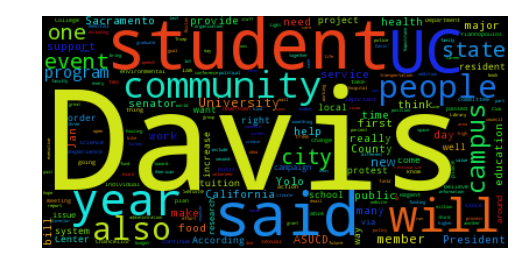

In [759]:
text = corpus.str.cat(sep=' ')
wordcloud = WordCloud(max_font_size=120).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

* I think this corpus of news do represent Aggie. From the wordcloud we can easily find words like UCDavis, Student, Community, Major and Health which could be strong evidence for Aggies' daily and study life.
* From the most common topic, one can easily find 'bike' and 'tuition'. As we all know that, davis is the largest bike city of US and almost every has at least one bike. The corpus may tells as that people in UCD are still concern about their bikes and crimes about bikes happens extremely often these days. Moreover, student may feel painful for the high tuition fee since 'tution' is a popular topic in the corpus.
* I also see senator shows up in the wordcloud and it may indicate that Aggies are talking about political issues these days a lot because of Trump being in charge.